# Variational autoencoder for MNIST

## Learning Objectives
1. Learn how Variational Autoencoder works
2. Learn how to build a Variational Autoencoder in Keras Functional API

In this lab, you will learn how to build a variational autoencoder (VAE) model. VAE is a popular extension of autoencoder that adds an extra step to sample data from a probabilistic distribution between an encoder and a decoder. <br>
By doing so, a VAE encoder can generate a more organized and smooth embedding space where all the embedding is located over a specified probabilistic distribution (usually standard normal distribution) without creating meaningless empty space inside it.<br>
These characteristics make decoders more robust, which leads to better reconstruction.

For details about a vanilla autoencoder and its application to anomaly detection, please refer to [autoencoder_anomaly_detection.ipynb](./autoencoder_anomaly_detection.ipynb) notebook. We recommend running the vanilla autoencoder version first, then running this VAE notebook by comparing the results.

This lab focuses on the implementation of a VAE, but you can also use this for anomaly detection purposes in the same way as vanilla autoencoders.

In [1]:
# Import libraries and modules
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

np.set_printoptions(threshold=np.inf)

### Load MNIST Data

We are going to use the same MNIST dataset, which consists of black and white images of handwritten digits. Each image has 28 x 28 pixels and a single channel indicating the level of gray between black and white, yielding a tensor representation with shape(28, 28, 1). Keras comes preloaded with this dataset, which we load in the next cell:"

In [2]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)

# Reshape from (28, 28) to (28, 28, 1) and rescale from [0, 255] to [0,1]
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

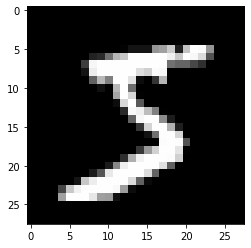

In [3]:
plt.imshow(mnist_digits[0], cmap="Greys_r")

## Build Variational Autoencoder
Let's start building a Variational Autoencoder (VAE).

VAE is a self-supervised model like a vanilla autoencoder, which uses the same data for input and label.<br>
Architecture is similar to autoencoder except that we sample the mean and variance of the latent dimension instead of directly passing the encoder's outputs to a decoder.

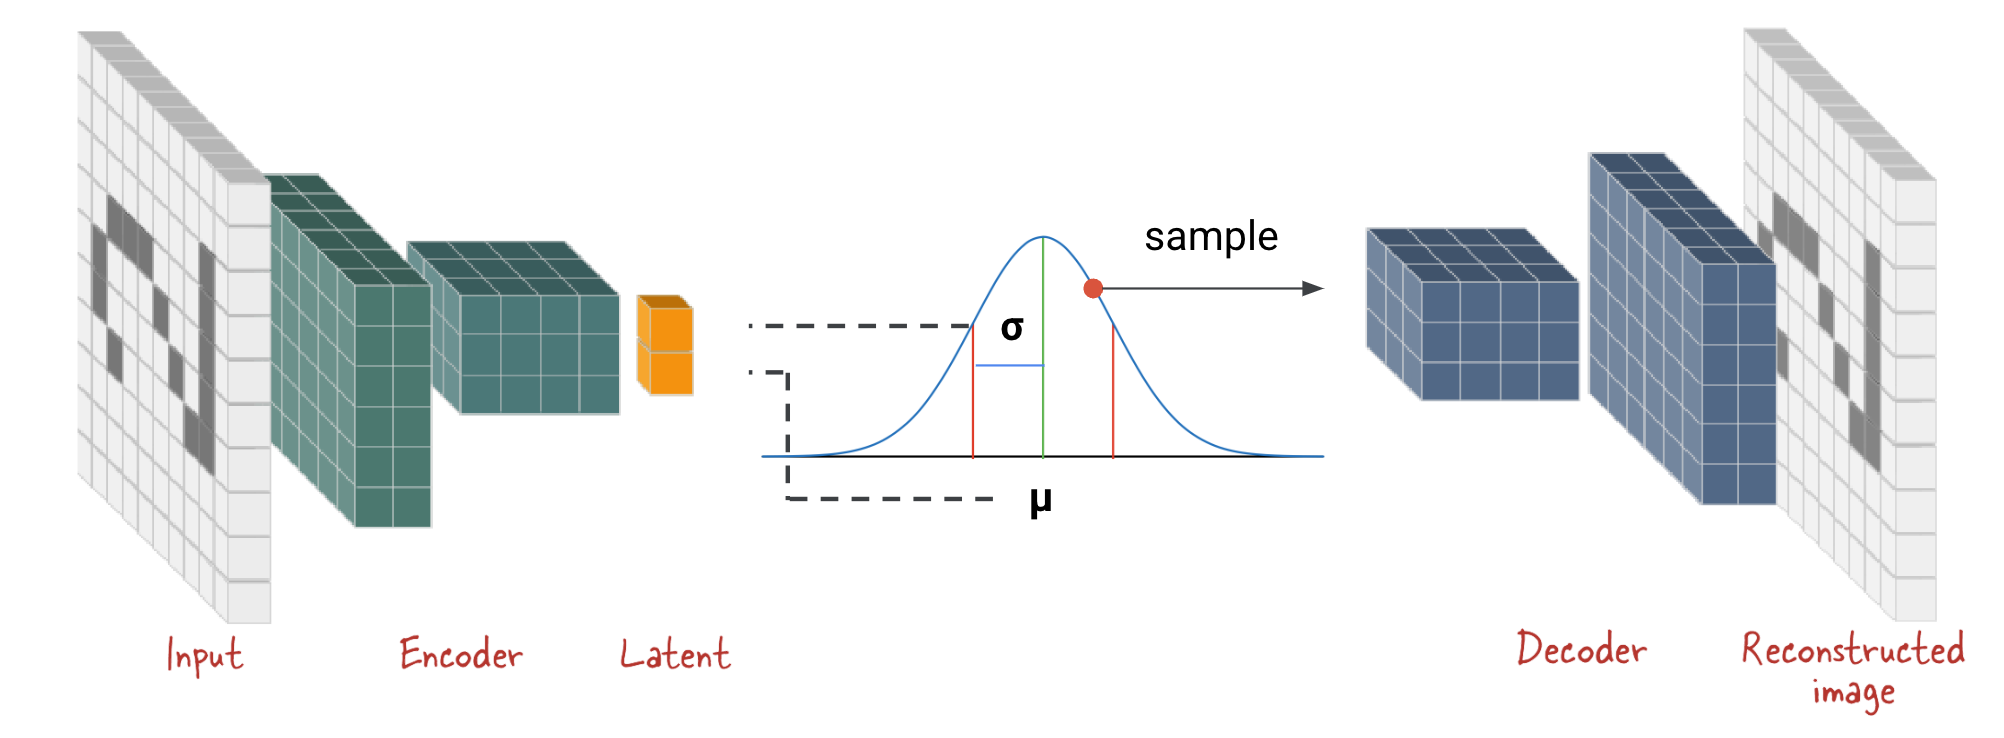

### Sampling layer with Reparametizing Trick
First, we define a Sampling layer that we insert at the end of a variational encoder. <br>
Conceptually, a VAE samples vectors from a normal distribution using (z_mean, z_log_var), which comes from an encoder. However, inserting a stochastic layer inside a neural network disconnects the backpropagation path and makes training impossible.

So, instead of implementing this as a stochastic layer, we use **Reparametizing Trick** that just 'reparametrize' deterministic vectors using sampled stochastic variables.

In [4]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, params):
        z_mean, z_log_var = params
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

### Encoder
Now let's define a variational encoder. The basic structure is the same as a vanilla autoencoder, except it has the `Sampling` layer we defined at the end of the network.

Also, because the architecture is not sequential now, we have to use the Functional API.

**Exercise**: Define encoder output using the `Sampling` layer.

**Hint**: After extracting features with `Conv2D` layers, the encoder has:
- `Flatten` layer to flatten 3D tensors to 1D.
- `Dense` layers to create parameters of Gaussian distribution which are $\mu$ and $\sigma$ (Here we use the log of $\sigma$)
- `Sampling` layer to generate encoder outputs.

In [5]:
def build_encoder(
    input_shape,
    latent_dim,
    filters_1=32,
    filters_2=64,
    kernel_size_1=3,
    kernel_size_2=3,
    strides_1=2,
    strides_2=2,
):
    encoder_inputs = keras.Input(shape=(28, 28, 1), name="image_input")

    x = layers.Conv2D(
        filters=filters_1,
        kernel_size=kernel_size_1,
        activation="relu",
        strides=strides_1,
        padding="same",
        name="encoder_convolution_1",
    )(encoder_inputs)

    x = layers.Conv2D(
        filters=filters_2,
        kernel_size=kernel_size_2,
        activation="relu",
        strides=strides_2,
        padding="same",
        name="encoder_convolution_2",
    )(x)

    # TODO: Define the output of encoder.

    # TODO: Define the encoder model
    encoder = keras.Model(...)

    return encoder

In [6]:
LATENT_DIM = 2  # for easy visualization
INPUT_SHAPE = (28, 28, 1)  # Size of input data

encoder = build_encoder(INPUT_SHAPE, LATENT_DIM)
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
encoder_convolution_1 (Conv2D)  (None, 14, 14, 32)   320         image_input[0][0]                
__________________________________________________________________________________________________
encoder_convolution_2 (Conv2D)  (None, 7, 7, 64)     18496       encoder_convolution_1[0][0]      
__________________________________________________________________________________________________
e_flatten (Flatten)             (None, 3136)         0           encoder_convolution_2[0][0]      
____________________________________________________________________________________________

2022-12-21 20:19:40.529437: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-21 20:19:40.540848: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-21 20:19:40.541544: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-21 20:19:40.542911: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Let's plot and check the variational encoder architecture.

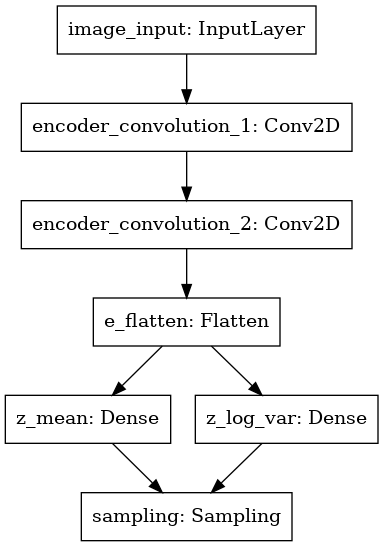

In [7]:
tf.keras.utils.plot_model(encoder)

### Decoder
The decoder goes from the latent dim back to the reconstructed image. This architecture is exactly the same as a vanilla autoencoder.

**Exercise**: Define the decoder architecture.

**Hint**: You can refer to the [object_detection_automl_vertex.ipynb](https://github.com/GoogleCloudPlatform/asl-ml-immersion/blob/master/notebooks/image_models/solutions/object_detection_automl_vertex.ipynb), but please note that the order of the encoder layers is different from the vanilla autoencoder.

In [8]:
def build_decoder(latent_dim, encoder):
    # TODO: Define the decoder
    decoder = ...
    return decoder

In [9]:
decoder = build_decoder(LATENT_DIM, encoder)
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_dense (Dense)       (None, 3136)              9408      
                                                                 
 decoder_reshape (Reshape)   (None, 7, 7, 64)          0         
                                                                 
 decoder_deconvolution_1 (Co  (None, 14, 14, 32)       18464     
 nv2DTranspose)                                                  
                                                                 
 decoder_deconvolution_2 (Co  (None, 28, 28, 1)        289       
 nv2DTranspose)                                                  
                                                                 
Total params: 28,161
Trainable params: 28,161
Non-trainable params: 0
_________________________________________________________________


### Construct entire VAE

The VAE consists of the encoder and the decoder blocks. Let's stack these two and build the entire VAE model.<br>
We use Functional API here again to allow multiple outputs from the encoder.

In [10]:
def build_autoencoder(input_shape, latent_dim):
    encoder_inputs = keras.Input(shape=(28, 28, 1), name="image_input")

    z_mean, z_log_var, z = encoder(encoder_inputs)  # three outputs
    decoder_output = decoder(z)
    vae = keras.Model(encoder_inputs, decoder_output, name="vae")

    return encoder, decoder, vae

In [11]:
encoder, decoder, vae = build_autoencoder(INPUT_SHAPE, LATENT_DIM)

vae.summary()

Model: "vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_input (InputLayer)    [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        [(None, 2),               31364     
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Sequential)        (None, 28, 28, 1)         28161     
                                                                 
Total params: 59,525
Trainable params: 59,525
Non-trainable params: 0
_________________________________________________________________


## Loss Function
Now let's define loss functions.<br>
A vanilla autoencoder just had a reconstruction loss that compares the inputs and outputs of a model. However, a VAE also tries to directly penalize its latent space (encoder's output) using an additional loss function called **Latent Loss**.

### Latent Loss: Kullback-Leibler Divergence
For a latent loss, we use **Kullback-Leibler Divergence**, which computes a divergence of a probabilistic distribution from another probabilistic distribution.

The KL divergence of a distribution $P$ from another distribution $Q$ is given by:

$D_{KL}(P||Q) = \int_x{P(x)\log{\frac{P(x)}{Q(x)}}}$


And the KL divernce of a normal distribution with ($\mu$, $\sigma$) from the standard normal distribution where $\mu = 0$ and $\sigma = 1$ is:

$D_{KL}(P||Q) = -\frac{1}{2}\big(1 + \log(\sigma) - \mu^2 - \sigma \big)$

Now we can implement this function and add it as a loss of encoder.

**Exercise**: Define the `kl_divergence` function referring to the equation above.

In [12]:
def kl_divergence(z_mean, z_log_var):
    # TODO: Define this function
    return ...


z_mean = encoder.layers[4].output
z_log_var = encoder.layers[5].output

encoder.add_loss(kl_divergence(z_mean, z_log_var))

### Reconstruction Loss: Pixel-wise Cross Entropy

And we define an overall reconstruction loss. <br>
We can use MSE as we did in [autoencoder_anomaly_detection.ipynb](./autoencoder_anomaly_detection.ipynb), but here we use the sum of pixel-wise binary cross-entropy loss, just because it is easier to balance with the latent loss.

In [13]:
def reconstruction_loss(real, reconstruction):
    return tf.reduce_mean(
        tf.reduce_sum(
            keras.losses.binary_crossentropy(real, reconstruction), axis=(1, 2)
        )
    )


vae.compile(
    optimizer=keras.optimizers.Adam(), loss=reconstruction_loss, metrics=["mse"]
)

## Train VAE
Now let's run the training by calling `.fit()`.

In [14]:
history = vae.fit(mnist_digits, mnist_digits, epochs=30, batch_size=128)

Epoch 1/30


2022-12-21 20:19:43.544206: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8200


547/547 [==============================] - 6s 5ms/step - loss: 214.0208 - mse: 0.0685
Epoch 2/30
547/547 [==============================] - 3s 5ms/step - loss: 173.1618 - mse: 0.0523
Epoch 3/30
547/547 [==============================] - 3s 5ms/step - loss: 167.4409 - mse: 0.0496
Epoch 4/30
547/547 [==============================] - 3s 5ms/step - loss: 163.8595 - mse: 0.0478
Epoch 5/30
547/547 [==============================] - 3s 5ms/step - loss: 161.6556 - mse: 0.0467
Epoch 6/30
547/547 [==============================] - 3s 5ms/step - loss: 160.0942 - mse: 0.0459
Epoch 7/30
547/547 [==============================] - 3s 5ms/step - loss: 159.0878 - mse: 0.0454
Epoch 8/30
547/547 [==============================] - 3s 5ms/step - loss: 158.2760 - mse: 0.0450
Epoch 9/30
547/547 [==============================] - 3s 5ms/step - loss: 157.6691 - mse: 0.0447
Epoch 10/30
547/547 [==============================] - 3s 5ms/step - loss: 157.1694 - mse: 0.0445
Epoch 11/30
547/547 [===================

## Visualize the latent space
We trained a VAE model with LATENT_DIM=2. Let's visualize the 2-dimensional latent space (output of encoder), and see how it found the pattern from input data. 

The function below will plot the input images in the latent space by passing them to the encoder. It will also add the indication of the actual image labels (which were not used during the autoencoder training). 

Compared to a vanilla autoencoder, please note that data is roughly centered at around 0 value, and the range is not very asymmetric (not something like [-5, 20]) because we penalize the VAE using KL divergence from the standard normal distribution.

In [15]:
def plot_label_clusters(encoder, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    for label in range(10):  # mnist, 10 digits
        cx = np.mean(z_mean[labels == label, 0])
        cy = np.mean(z_mean[labels == label, 1])
        plt.text(
            cx, cy, str(label), color="white", fontsize=25, fontweight="bold"
        )
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

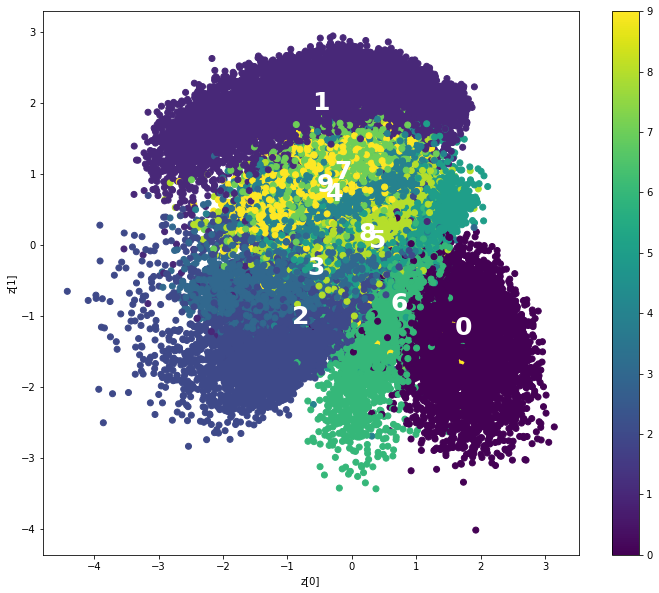

In [16]:
(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255
plot_label_clusters(encoder, x_train, y_train)

## Visualize decoder
Now let's take a look at the decoder part as well. The helper function below creates grid pairs of two-dimensional latent space (grid_x and grid_y) in a specified range, then passes them to the decoder and plots the decoder model's output.
It helps us understand how the decoder generates output images from latent spaces.


In [17]:
def plot_latent_space(decoder, n=30, ranges=[-1, 1, -1, 1], figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(ranges[0], ranges[1], n)
    grid_y = np.linspace(ranges[2], ranges[3], n)[::-1]

    samples = [[x, y] for y in grid_y for x in grid_x]
    x_decoded = decoder.predict(samples)
    figure = np.zeros((digit_size * n, digit_size * n))
    for i in range(n):
        for j in range(n):
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = x_decoded[i * n + j].reshape(digit_size, digit_size)

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

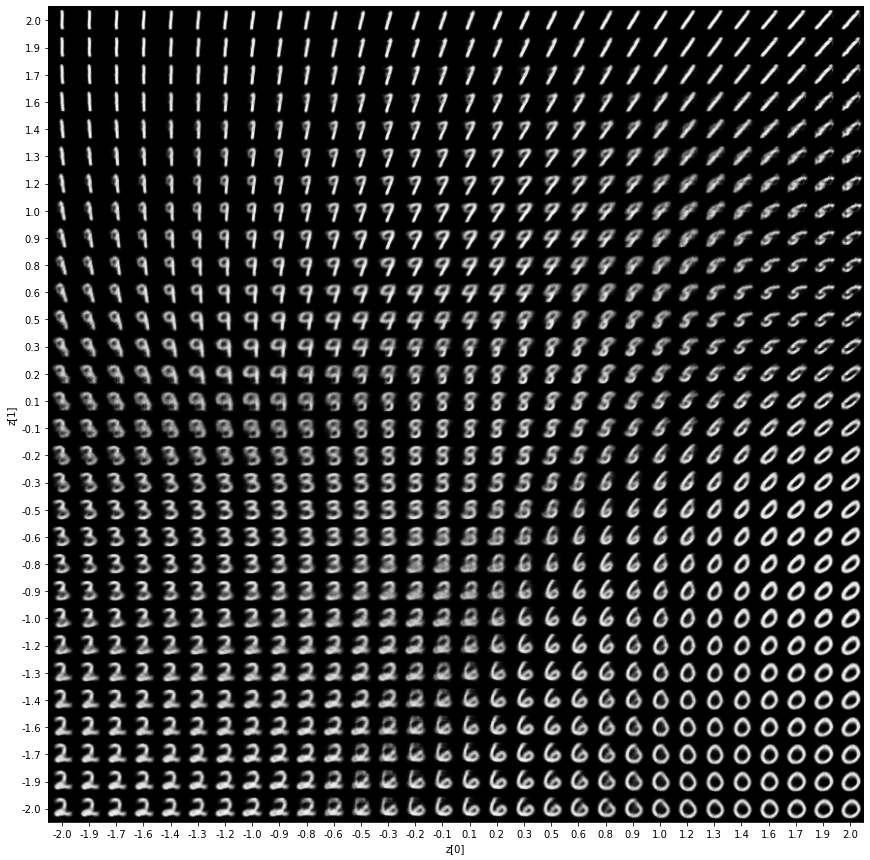

In [18]:
plot_latent_space(decoder, n=30, ranges=[-2, 2, -2, 2], figsize=15)

It looks good! <br>
Again, compared to the vanilla autoencoder, most of the digits are well clustered inside the specified `[-2, 2]` range because of the latent loss we used.

Copyright 2022 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.